## 3. InceptionV3 Fine Tune
### Result:
- 

### References:
1. https://github.com/ypwhs/dogs_vs_cats
2. https://www.kaggle.com/yangpeiwen/keras-inception-xception-0-47

### Import pkgs

In [1]:
import cv2
import numpy as np
from tqdm import tqdm
import pandas as pd
import os, time
import random
import matplotlib.pyplot as plt
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

from keras.applications.inception_v3 import InceptionV3, preprocess_input

### Run name

In [3]:
project_name = 'Dog_Breed_Identification'
step_name = 'InceptionV3FineTune'
date_str = time.strftime("%Y%m%d", time.localtime())
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)

run_name: Dog_Breed_Identification_InceptionV3FineTune_20171105_150015


### Basic folders

In [4]:
cwd = os.getcwd()
input_path = os.path.join(cwd, 'input')
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')
print('input_path: ' + input_path)
print('log_path: ' + log_path)
print('model_path: ' + model_path)
print('output_path: ' + output_path)

input_path: E:\Udacity\MachineLearning(Advanced)\p6_graduation_project\input
log_path: E:\Udacity\MachineLearning(Advanced)\p6_graduation_project\log
model_path: E:\Udacity\MachineLearning(Advanced)\p6_graduation_project\model
output_path: E:\Udacity\MachineLearning(Advanced)\p6_graduation_project\output


### Load data

In [5]:
cwd = os.getcwd()
df = pd.read_csv(os.path.join(cwd, 'input', 'labels.csv'))
print('lables amount: %d' %len(df))
df.head()

lables amount: 10222


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [6]:
n = len(df)
breed = set(df['breed'])
n_class = len(breed)
breed = sorted(breed)
print(breed)
class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

### Build method

In [7]:
def build_model():
    # create the base pre-trained model
    base_model = InceptionV3(weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(2048, activation='relu')(x)
    x = Dense(2048, activation='relu')(x)

    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(120, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer = Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [8]:
model = build_model()
# model.summary()

In [9]:
def saveModel(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, run_name + '.h5')
    model.save(weigthsFile)
# saveModel(model, 'saveModel_test')

In [10]:
data_train_path = os.path.join(input_path, 'data_train')
data_val_path = os.path.join(input_path, 'data_val')
data_test_path  = os.path.join(input_path, 'data_test')

image_size = (299, 299)
seed = 3
batch_size = 64

#     gen = ImageDataGenerator()
train_gen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 20,
                                   zoom_range = 0.1,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip = True,
                                   vertical_flip = True)
val_gen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 20,
                                   zoom_range = 0.1,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip = True,
                                   vertical_flip = True)
test_gen = ImageDataGenerator(rescale=1./255)
train_generator = train_gen.flow_from_directory(data_train_path, 
                                          target_size=image_size, 
                                          shuffle=True,
                                          seed=seed,
                                          class_mode = "categorical",
                                          batch_size=batch_size)
val_generator = val_gen.flow_from_directory(data_val_path, 
                                        target_size=image_size, 
                                        shuffle=False,
#                                         seed=seed,
                                        class_mode = "categorical",
                                        batch_size=batch_size)
test_generator  = test_gen.flow_from_directory(data_test_path,
                                          target_size=image_size, 
                                          shuffle=False,
                                          class_mode = "categorical",
                                          batch_size=batch_size)
print(train_generator.classes[0:100])
print(val_generator.classes[0:100])
print(test_generator.classes[0:100])

Found 9710 images belonging to 120 classes.
Found 512 images belonging to 120 classes.
Found 10357 images belonging to 1 classes.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[ 0  0  0  0  1  2  2  2  2  2  2  3  3  3  3  3  3  3  4  4  4  4  4  4  4
  5  5  5  5  6  6  6  6  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8
  9  9  9 10 10 10 10 10 11 11 11 11 11 11 11 11 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 14 14 14 14 14 14 15 15 15 16 16 17 17 17 18 18 18 19 19 19]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [11]:
# def get_lr(x):
#     lr = round(1e-3 * 0.9 ** x, 6)
#     if lr < 1e-4:
#         lr = 1e-4
#     print(lr, end='  ')
#     return lr
def get_lr(x):
    n = 20
    lr = 1e-3
    if x > n:
        lr = round(1e-3 * 0.9 ** (x-n), 6)
        if lr < 1e-4:
            lr = 1e-4
    print(lr, end='  ')
    return lr

get_lr(10) # Test
get_lr(15) # Test
get_lr(20) # Test
get_lr(30) # Test
get_lr(40) # Test
get_lr(50) # Test

# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
annealer = LearningRateScheduler(get_lr)

log_dir = os.path.join(log_path, run_name)
print('log_dir:' + log_dir)
tensorBoard = TensorBoard(log_dir=log_dir)

0.001  0.001  0.001  0.000349  0.000122  0.0001  log_dir:E:\Udacity\MachineLearning(Advanced)\p6_graduation_project\log\Dog_Breed_Identification_InceptionV3FineTune_20171105_150015


In [12]:
steps_per_epoch = int(len(train_generator.classes)/batch_size)
validation_steps = int(len(val_generator.classes)/batch_size)
test_steps = int(len(test_generator.classes)/batch_size)+1
print(steps_per_epoch)
print(validation_steps)
print(test_steps)
print(len(test_generator.classes), test_steps*batch_size)

151
8
162
10357 10368


In [13]:
%%time
hist = model.fit_generator(train_generator,
                 steps_per_epoch=steps_per_epoch, 
                 epochs=50, 
                 verbose=2, 
                 callbacks=[annealer, tensorBoard], 
                 validation_data=val_generator, 
                 validation_steps=validation_steps, 
                 class_weight=None, 
                 max_queue_size=128, 
                 workers=32, 
                 use_multiprocessing=False, 
                 shuffle=False, 
                 initial_epoch=0)

0.001  Epoch 1/50
139s - loss: 2.9992 - acc: 0.3156 - val_loss: 1.7548 - val_acc: 0.5488
0.001  Epoch 2/50
130s - loss: 1.9069 - acc: 0.4894 - val_loss: 1.7028 - val_acc: 0.5625
0.001  Epoch 3/50
121s - loss: 1.7400 - acc: 0.5302 - val_loss: 1.5598 - val_acc: 0.5957
0.001  Epoch 4/50
123s - loss: 1.6483 - acc: 0.5533 - val_loss: 1.8469 - val_acc: 0.4961
0.001  Epoch 5/50
121s - loss: 1.5664 - acc: 0.5717 - val_loss: 1.5610 - val_acc: 0.5918
0.001  Epoch 6/50
127s - loss: 1.5479 - acc: 0.5792 - val_loss: 1.5175 - val_acc: 0.6094
0.001  Epoch 7/50
112s - loss: 1.4767 - acc: 0.5911 - val_loss: 1.4702 - val_acc: 0.6094
0.001  Epoch 8/50
103s - loss: 1.4511 - acc: 0.6019 - val_loss: 1.6709 - val_acc: 0.5586
0.001  Epoch 9/50
116s - loss: 1.3811 - acc: 0.6129 - val_loss: 1.4819 - val_acc: 0.6074
0.001  Epoch 10/50
124s - loss: 1.3609 - acc: 0.6229 - val_loss: 1.6801 - val_acc: 0.5742
0.001  Epoch 11/50
109s - loss: 1.3072 - acc: 0.6310 - val_loss: 1.4366 - val_acc: 0.6270
0.001  Epoch 12/50


In [14]:
%%time
final_loss, final_acc = model.evaluate_generator(val_generator, steps=validation_steps, max_queue_size=128, workers=32, use_multiprocessing=False)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 1.3473, final accuracy: 0.6914
Wall time: 24.5 s


In [15]:
run_name_acc = run_name + '_' + str(int(final_acc*10000)).zfill(4)
print(run_name_acc)

Dog_Breed_Identification_InceptionV3FineTune_20171105_150015_6914


In [16]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_path, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

Index(['acc', 'loss', 'val_acc', 'val_loss', 'epoch'], dtype='object')


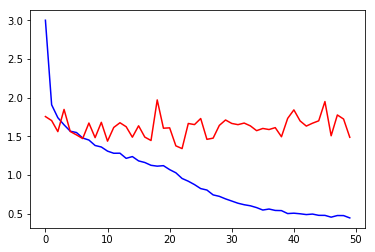

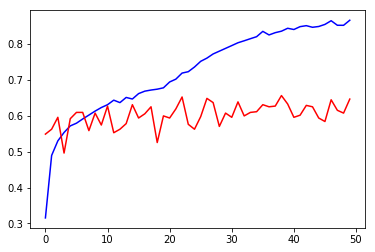

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [18]:
saveModel(model, run_name_acc)

### Predict

In [19]:
df2 = pd.read_csv('.\\input\\sample_submission.csv')
n_test = len(df2)
print(df2.shape)

(10357, 121)


In [20]:
%%time
y_pred = model.predict_generator(test_generator, steps=test_steps, max_queue_size=128, workers=16, use_multiprocessing=False, verbose=1)
print(y_pred.shape)

162/162 [==============================] - ETA: 94 - ETA: 50 - ETA: 36 - ETA: 29 - ETA: 24 - ETA: 22 - ETA: 20 - ETA: 18 - ETA: 17 - ETA: 16 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 98s - ETA: 97 - ETA: 95 - ETA: 93 - ETA: 92 - ETA: 90 - ETA: 89 - ETA: 88 - ETA: 87 - ETA: 86 - ETA: 84 - ETA: 83 - ETA: 82 - ETA: 81 - ETA: 80 - ETA: 79 - ETA: 78 - ETA: 77 - ETA: 76 - ETA: 75 - ETA: 74 - ETA: 73 - ETA: 72 - ETA: 72 - ETA: 71 - ETA: 70 - ETA: 69 - ETA: 68 - ETA: 67 - ETA: 67 - ETA: 66 - ETA: 65 - ETA: 64 - ETA: 63 - ETA: 63 - ETA: 62 - ETA: 61 - ETA: 61 - ETA: 60 - ETA: 59 - ETA: 58 - ETA: 58 - ETA: 57 - ETA: 56 - ETA: 55 - ETA: 55 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 3

In [21]:
print(y_pred.shape)
y_pred = y_pred[0:n_test]
print(y_pred.shape)
# print(y_pred[-10:-5])
# print(test_generator.filenames[-10:-5])
# print(df2[-10:-5])

(10368, 120)
(10357, 120)


In [22]:
for i in range(0, 120):
    df2.iloc[:,[i+1]] = y_pred[:,i]
if not os.path.exists(output_path):
    os.mkdir(output_path)
pred_file = os.path.join(output_path, 'pred_' + run_name_acc + '.csv')
df2.to_csv(pred_file, index=None)

In [23]:
print(run_name_acc)
print('Done!')

Dog_Breed_Identification_InceptionV3FineTune_20171105_150015_6914
Done!
